### Import Statements

In [6]:
import requests
import fitz  # PyMuPDF
import contextlib
import re
import torch
import numpy as np
import os
from numpy.typing import ArrayLike
import random

### Model loading

Loading the pytorch version of Gemma 7b Instruct (int8 quantized)

In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/gemma/transformers/7b-it/3")
model = AutoModelForCausalLM.from_pretrained("/kaggle/input/gemma/transformers/7b-it/3", quantization_config=quantization_config)

def generate(model, tokenizer, prompt, verbose, max_tokens):
    input_ids = tokenizer(prompt, return_tensors="pt")#.to("cuda")
    outputs = model.generate(**input_ids, max_length=max_tokens)
    return tokenizer.decode(outputs[0])

In [2]:
from mlx_lm import load, generate

model, tokenizer = load("mlx-community/quantized-gemma-7b-it")

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

### Data Retriaval
Download of the pdf file(s)

In [9]:
pdfs = ["https://bugs.python.org/file47781/Tutorial_EDIT.pdf", "https://static.realpython.com/python-basics-sample-chapters.pdf", "https://numpy.org/doc/1.18/numpy-user.pdf"]

def download_pdf(url):
    response = requests.get(url)
    with open('temp.pdf', 'wb') as f:
        f.write(response.content)
    return 'temp.pdf'

def pdf_to_text(filename):
    doc = fitz.open(filename)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

def clean_text(text):
    # Remove double spaces
    return re.sub(' +', ' ', text)

chunks = []
for pdf_url in pdfs:
    pdf_file = download_pdf(pdf_url)
    pdf_text = pdf_to_text(pdf_file)
    clean_pdf_text = clean_text(pdf_text)

    words = clean_pdf_text.split()

    # Decide on the number of chunks you want
    len_chunk = 256
    current_chunk = [' '.join(words[i:i + len_chunk]) for i in range(0, len(words), len_chunk)]
    chunks = chunks + current_chunk

# This will print the chunks, you can process them further as needed
print(f"Number of chunks: {len(chunks)}")
random_questions = random.sample(chunks, 5)
for i, chunk in enumerate(random_questions):
    print(f"Chunk {i}: {chunk[:100]}...") 

Number of chunks: 492
Chunk 0: (for clarity we neglect variable declarations and initializations, memory allocation, etc.) for (i =...
Chunk 1: LOSS AS A RESULT OF MODIFYING, DISTRIBUTING, OR OTHERWISE USING PYTHON 1.6.1, OR ANY DERIVATIVE THER...
Chunk 2: of 7 128 The equal sign (=) is used to assign a value to a variable. Afterwards, no result is displa...
Chunk 3: 5) >>> a array([[ 0, 1, 2, 3, 4], [ 5, 6, 7, 8, 9], [10, 11, 12, 13, 14]]) >>> a.shape (3, 5) >>> a....
Chunk 4: all ﬁelds. This happens when a scalar is assigned to a structured array, or when an unstructured arr...


### Data Cleaning
Using the 7B instruct model

In [10]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Calculate the differences between original and cleaned lengths
differences = []
new_data = []
for chunk in tqdm(chunks, desc="Calculating differences"):
    prompt = f"<start_of_turn>user Clean the following data so that only relevant content remains and unneccessary signs are removed. Do not make stuff up on your own or add any explanation: {chunk} <start_of_turn>model Sure, here is the cleaned data:"
    response = generate(model, tokenizer, prompt=prompt, verbose=False, max_tokens=2000)
    differences.append(len(response) / len(chunk))
    new_data.append(response)

Calculating differences: 100%|██████████| 492/492 [52:08<00:00,  6.36s/it]  


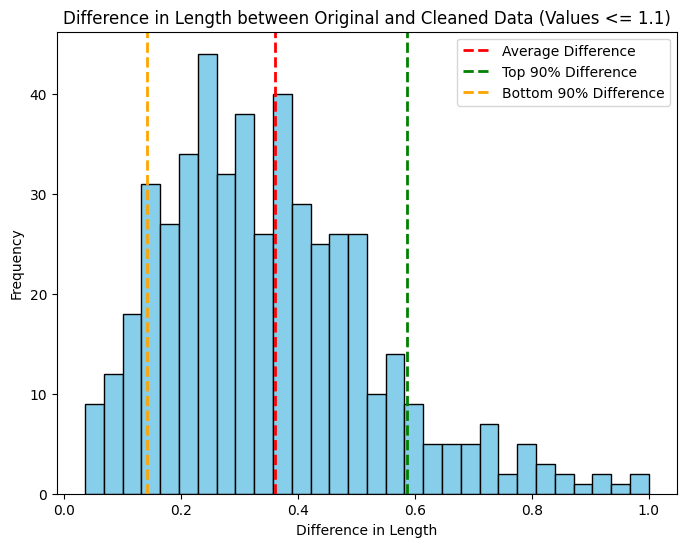

In [29]:
# Calculate the average difference
average_difference = np.mean(differences)

# Calculate the top and bottom 90% differences
top_90_percentile = np.percentile(differences, 90)
bottom_90_percentile = np.percentile(differences, 10)

# Filter differences larger than 1.1
filtered_differences = [diff for diff in differences if diff <= 1.1]

# Plot the filtered differences
plt.figure(figsize=(8, 6))
plt.hist(filtered_differences, bins=30, color='skyblue', edgecolor='black')
plt.axvline(average_difference, color='red', linestyle='dashed', linewidth=2, label='Average Difference')
plt.axvline(top_90_percentile, color='green', linestyle='dashed', linewidth=2, label='Top 90% Difference')
plt.axvline(bottom_90_percentile, color='orange', linestyle='dashed', linewidth=2, label='Bottom 90% Difference')
plt.xlabel('Difference in Length')
plt.ylabel('Frequency')
plt.title('Difference in Length between Original and Cleaned Data (Values <= 1.1)')
plt.legend()
plt.savefig('plots/difference_in_length.png')
plt.show()

In [12]:
import re
new_text = "\n".join(new_data)
len_chunk = 256

new_words = new_text.split()
current_chunk = [' '.join(new_words[i:i + len_chunk]) for i in range(0, len(new_words), len_chunk)]
# chunks = split_text_into_chunks(new_text, 5)

chapter_text = []
for chunk in tqdm(current_chunk, desc="Seperating into senseful chunks"):
    prompt = f"<start_of_turn>user Add 'Chunk' at every headline, where a new chapter begins: {chunk} <start_of_turn>model Sure, here is the seperated text:"
    response = generate(model, tokenizer, prompt=prompt, verbose=False, max_tokens=2000)
    chapter_text.append(response)

Seperating into senseful chunks: 100%|██████████| 166/166 [31:56<00:00, 11.55s/it]


In [13]:
new_text = "\n".join(chapter_text)
# Split the text 2 indices before every mention of "chapter" into a list of strings
split_text = re.split(r"(?<=\bChunk\b)", new_text)

# Remove leading and trailing whitespaces from each string
split_text = [text.strip() for text in split_text]
len(split_text)

305

### Embedding Function
for ChromaDB

In [30]:
import chromadb as db  # This helps us work with the vectors database
from chromadb.utils import embedding_functions  # This helps us fetch our embedding model
from chromadb import Documents, EmbeddingFunction, Embeddings
from sentence_transformers.util import cos_sim, dot_score

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import string

class Embedding(EmbeddingFunction):
    def __init__(self):
        self.embedding_model = embedding_functions.SentenceTransformerEmbeddingFunction('thenlper/gte-large')  # ("Salesforce/SFR-Embedding-Mistral") (7b)

    def encode(self, input: Documents) -> Embeddings:
        embeddings = self.embedding_model(input)
        return embeddings
    
    def __call__(self, input: Documents) -> Embeddings:
        embeddings = self.embedding_model(input)
        return embeddings

    def distance(self, x: ArrayLike, y: ArrayLike) -> float:
        return cos_sim(x, y)

    def plot(self, query: str, documents: Documents) -> None:
        query = query[0] if isinstance(query, list) and len(query) == 1 else query
        texts = [query] + documents if query else documents
        embeddings = self.encode(texts)
        tsne_results = TSNE(n_components=2, perplexity=min(30, len(embeddings) - 1)).fit_transform(np.array(embeddings))
        cluster_labels = DBSCAN(eps=0.9, min_samples=2).fit(tsne_results[1:]).labels_ if query else DBSCAN(eps=0.5, min_samples=2).fit(tsne_results).labels_

        plt.figure(figsize=(12, 8))
        plt.axis('off')
        if query:
            plt.scatter(tsne_results[0, 0], tsne_results[0, 1], c='red', label='Query', s=100)
            plt.annotate(query, (tsne_results[0, 0], tsne_results[0, 1]), fontsize=9, alpha=0.7, color='black')

        scatter = plt.scatter(tsne_results[1:, 0], tsne_results[1:, 1], c=cluster_labels, cmap='Pastel2', alpha=0.85)

        FILLER_WORDS = set([
            'the', 'and', 'a', 'to', 'of', 'in', 'i', 'is', 'that', 'on', 
            'for', 'it', 'with', 'as', 'this', 'by', 'are', 'be', 'was', 'or', 'you', 'an',
        ])

        # Find and annotate clusters with frequent words
        for label in set(cluster_labels):
            if label == -1:  # Ignore noise
                continue
            cluster_docs = [documents[i] for i, lbl in enumerate(cluster_labels) if lbl == label]
            words = ' '.join(cluster_docs).lower().split()
            words = [word.strip(string.punctuation) for word in words if word not in FILLER_WORDS and word.strip(string.punctuation) not in FILLER_WORDS]
            word_counts = Counter(words)
            most_common_words = ' '.join(word for word, count in word_counts.most_common(3))  # Get top 3 words

            cluster_center = np.mean([tsne_results[i + 1] for i, lbl in enumerate(cluster_labels) if lbl == label], axis=0)
            plt.annotate(most_common_words, (cluster_center[0], cluster_center[1]), fontsize=9, alpha=0.7, color='black')

        plt.grid(True, which='both', linestyle='--', linewidth=0.2)
        plt.savefig('plots/cluster_plot.png')
        plt.savefig('plots/cluster_plot.pdf')
        plt.show()

In [31]:
embedding_model = Embedding()

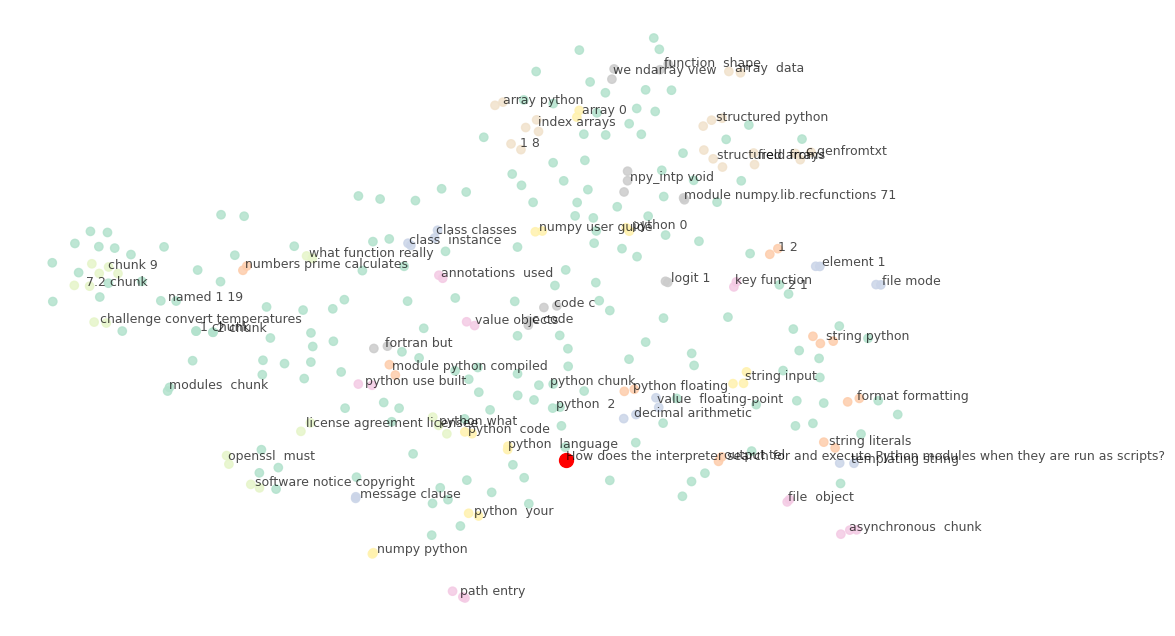

In [32]:
embedding_model.plot(["How does the interpreter search for and execute Python modules when they are run as scripts?"], split_text)

### Data Loading
Loading the data into ChromaDB

In [17]:
import chromadb
from chromadb.utils import embedding_functions # This helps us fetch our embedding model

client = chromadb.PersistentClient(path="./chromadb")

ids = [f"Tutorial_{i}" for i in range(len(split_text))]
metadata = [{"id": f"Tutorial_{i}"} for i in range(len(split_text))]

collection_exists = "Python-RAG" in [collection.name for collection in client.list_collections()]
if not collection_exists:
    collection = client.create_collection(
        name=f"Python-RAG",
        metadata={"hnsw:space": "cosine"}, # l2 is the default
        embedding_function=embedding_model,
    )
    collection.add(
        documents=split_text,
        metadatas=metadata,
        ids=ids,
    )
else:
    collection = client.get_collection("Python-RAG")

In [18]:
print(len(split_text))

305


### Benchmarking
Benchmarking the retrieval process by automatically generating specific questions for each chunk and testing, whether the right document is retrieved.

In [19]:
data = collection.get()
questions = []
for id, document in tqdm(zip(data["ids"], data["documents"]), desc="Generating questions"):
    prompt = f"<start_of_turn>user Create a vague short question for this text. Do not refer to the text directly: {document} <start_of_turn>model Sure, here is the question:"
    question = generate(model, tokenizer, prompt=prompt, verbose=False, max_tokens=1000)
    question = question.replace("\n", "")
    question = question.replace("*", "")
    questions.append(question)

Generating questions: 305it [05:06,  1.01s/it]


In [20]:
import random
random_questions = random.sample(questions, 5)
for question in random_questions:
    print(question)

How does the interpreter handle the comparison of objects of different types in Python?
What is the purpose of the code snippet and what does it achieve?
What is the purpose of the disclaimer in the text?
What is the purpose of the code snippet in the text, and what is the meaning of the different parts of the code?
What is the relationship between the use of operators and the use of the array in the text?


In [21]:
accuracies = {}
lengths = [1, 2, 3, 4, 5]
for n_results in lengths:
    datapoints = []
    for id, question in zip(data["ids"], questions):
        results = collection.query(query_texts=question, n_results=n_results)
        result_ids = results["ids"][0]
        if id in result_ids:
            datapoints.append(1)
        else:
            datapoints.append(0)

    accuracies[n_results] = sum(datapoints) / len(datapoints)

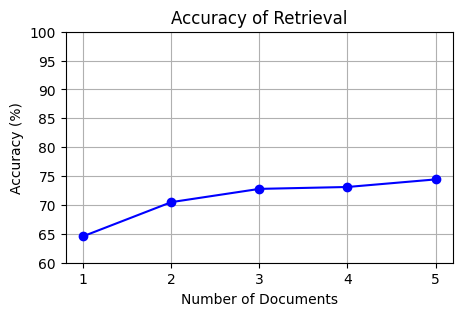

In [22]:
x = list(accuracies.keys())
y = [value * 100 for value in list(accuracies.values())]

plt.figure(figsize=(5, 3))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Retrieval')
plt.xlabel('Number of Documents')
plt.ylabel('Accuracy (%)')
plt.ylim(60, 100)  # Set y-axis limits to show percentages clearly
plt.grid(True)
plt.xticks(x)  # Ensure all x-axis values are shown
plt.savefig('plots/accuracy_of_retrieval.png')
plt.savefig('plots/accuracy_of_retrieval.pdf')
plt.show()

### RAG Class
Document retrieval and prompt engineering

In [25]:
class RAG:

    def __init__(self, model, tokenizer, collection) -> None:
        self.model = model
        self.tokenizer = tokenizer
        self.collection = collection

    def query(self, prompt, n_results=1):
        return self.collection.query(query_texts=prompt, n_results=n_results)
    
    def generate_text(self, prompt: str) -> str:
        result = self.collection.query(
            query_texts=prompt,
            n_results=3,
        )
        documents = ' '.join(result["documents"][0])
        prompt = f"<start_of_turn>user You are an assistant. Answer the following question based on the following knowledge base. Knowledge Base: {documents}\n Question: {prompt} <start_of_turn>model Sure, here is the answer to the question based on the knowledge base:"
        output = generate(self.model, self.tokenizer, prompt=prompt, verbose=False, max_tokens=1000)
        return output

### LLM Generating Answers
Including a Chat Interface

In [27]:
from IPython.display import display, Markdown, Latex

rag = RAG(model, tokenizer, collection)
display(Markdown(rag.generate_text("How does the interpreter search for and execute Python modules when they are run as scripts?")))



The Python interpreter searches for and executes Python modules when they are run as scripts by following a specific process:

1. **Search Path:** After initialization, Python programs can modify sys.path to include the directory containing the script being run at the beginning of the search path. This ensures that the script is found before any standard library modules.

2. **Cache Check:** Python checks the modification date of the source module against the compiled version to see if it's out of date and needs to be recompiled. If the source module is out of date, it recompiles the module and stores the compiled version in the cache for future use.

3. **Module Loading:** If the module is loaded directly from the command line or there is no source module, Python does not check the cache and recompiles the module.

This process is repeated for each module that is imported by the script, and it is completely automatic.